In [1]:
# Install required libraries
%pip install igraph matplotlib numpy scipy nbimporter --quiet

Note: you may need to restart the kernel to use updated packages.


In [9]:
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import numpy as np
import os 
from scipy.spatial import ConvexHull

# Testing community structure
import nbimporter
from _functions import community_detection, load_graph_from_gml_file, test_community_structure

In [10]:
def report_clustering_details(graph, clusters, title="Community Detection Results"):
    if not isinstance(clusters, ig.clustering.VertexClustering):
        print(f"Error: {title} received an invalid clusters object (expected igraph.clustering.VertexClustering).")
        return None, None # Return None for memberships and map

    print(f"\n--- {title} ---")
    print(f"Number of communities: {len(clusters)}")
    print(f"Modularity: {clusters.modularity:.4f}")

    memberships = clusters.membership
    community_map = {}
    for i, member_id in enumerate(memberships):
        if member_id not in community_map:
            community_map[member_id] = []
        member_name = str(graph.vs[i]['label'])
        community_map[member_id].append(member_name)

    print(f"\nCommunities (showing full member list):")
    for community_id, members in sorted(community_map.items()):
        print(f"  Community {community_id} ({len(members)} members): {', '.join(map(str, members))}")

    return memberships, community_map




In [11]:

def communities_w_shading_viz(ax, graph, communities, title="Community Structure Visualization"):
    # Get node colors based on detected communities
    num_communities = len(communities)
    node_colors_map = plt.colormaps['tab10'] # Using 'tab10' as it's common and good for discrete categories
                                            # If more than 10 communities, consider 'tab20' or 'viridis' etc.
    vertex_colors = [node_colors_map(communities.membership[i] % node_colors_map.N) for i in range(graph.vcount())]
    # Use modulo operator (%) with node_colors_map.N to handle more communities than colors in 'tab10'
    # For example, if tab10 has 10 colors, community 10 will get color 0, community 11 will get color 1, etc.


    # --- 2. Force-Directed Layout ---
    layout = graph.layout("fr") # Fruchterman-Reingold layout for spatial separation of communities

    # --- 3. Edge Coloring (Black Edges like in your example) ---
    edge_colors = ["black"] * graph.ecount()
    edge_width = 0.8

    ax.set_facecolor('white') # Explicitly set background to white

    # Plot the graph first
    ig.plot(
        graph,
        target=ax,
        layout=layout,
        vertex_color=vertex_colors, # Use the computed vertex_colors list
        vertex_size=30, # Adjust size as needed
        vertex_label=[str(i) for i in range(graph.vcount())], # Use graph.vcount() here
        vertex_label_size=10, # Adjusted for better visibility in plots
        vertex_label_color="black",
        edge_color=edge_colors,
        edge_width=edge_width,
        edge_curved=False,
        # bbox=(500, 500), # Not needed here as figsize handles the overall plot size
        margin=50
    )

    ax.set_title(title)
    
    # --- 5. Add Community Shading (Blobs) ---
    for i in range(num_communities):
        community_nodes_indices = [v.index for v in graph.vs if communities.membership[v.index] == i]

        if len(community_nodes_indices) > 2: # Need at least 3 points for a meaningful convex hull
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])

            try: # Use a try-except block for ConvexHull, as it can fail with collinear points
                hull = ConvexHull(community_coords)
                hull_points = community_coords[hull.vertices]

                patch = plt.Polygon(hull_points,
                                    facecolor=node_colors_map(i % node_colors_map.N), # Use the colormap directly
                                    alpha=0.2,
                                    edgecolor='none',
                                    zorder=0)
                ax.add_patch(patch)
            except Exception as e:
                # Handle cases where ConvexHull might fail (e.g., all points collinear)
                # For small communities (2 or 1 node), this block will be skipped due to len(community_nodes_indices) > 2 check
                print(f"Warning: Could not draw convex hull for community {i}. Error: {e}")
                # Fallback for very small or problematic communities:
                if len(community_coords) == 1:
                    ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
                elif len(community_coords) == 2:
                    min_x, min_y = np.min(community_coords, axis=0)
                    max_x, max_y = np.max(community_coords, axis=0)
                    center_x = (min_x + max_x) / 2
                    center_y = (min_y + max_y) / 2
                    width = max_x - min_x + 0.1
                    height = max_y - min_y + 0.1
                    ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                                color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 1:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 2:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            min_x, min_y = np.min(community_coords, axis=0)
            max_x, max_y = np.max(community_coords, axis=0)
            width = max_x - min_x + 0.1
            height = max_y - min_y + 0.1
            ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                        color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))


In [12]:
def clustered_adj_matrix_viz_on_ax(ax, graph, communities, weight_attribute_name="weight", title="Community Structure Visualization"):
    """
    Visualizes a reordered adjacency matrix based on community structure on a given matplotlib Axes object.

    Args:
        ax (matplotlib.axes.Axes): The axes object to draw the plot on.
        graph: The igraph Graph object.
        communities: The igraph VertexClustering object.
        weight_attribute_name (str, optional): The name of the edge attribute
                                               to use for weights. Defaults to "weight".
        title (str, optional): Title for the plot. Defaults to "Community Structure Visualization".
    """
    num_nodes = graph.vcount()
    node_memberships = communities.membership

    adj_matrix = np.array(graph.get_adjacency(attribute=weight_attribute_name).data)
    sorted_node_indices = sorted(range(num_nodes), key=lambda i: (node_memberships[i], i))
    reordered_adj_matrix = adj_matrix[sorted_node_indices, :][:, sorted_node_indices]

    # --- Color mapping logic (same as before) ---
    actual_weights = [edge[weight_attribute_name] for edge in graph.es if edge[weight_attribute_name] > 0]
    if actual_weights:
        min_positive_weight = min(actual_weights)
        max_actual_weight = max(actual_weights)
    else:
        min_positive_weight = 0.1
        max_actual_weight = 1

    epsilon = 1e-9
    vmin_gradient = min_positive_weight if min_positive_weight > 0 else epsilon

    n_colors = 255
    cmap_gradient = plt.colormaps.get_cmap('plasma_r')
    colors = cmap_gradient(np.linspace(0, 1, n_colors))
    all_colors = np.vstack([[1, 1, 1, 1], colors])
    custom_cmap = mcolors.ListedColormap(all_colors, name='CustomPlasmaReversedWhite')

    bounds = np.linspace(vmin_gradient, max_actual_weight, n_colors)
    norm = mcolors.BoundaryNorm(np.insert(bounds, 0, 0), custom_cmap.N)

    # --- Plotting on the provided axes 'ax' ---
    im = ax.imshow(reordered_adj_matrix, cmap=custom_cmap, origin='lower', norm=norm)

    ax.set_title(title)
    ax.set_xlabel('Node Index (reordered by community)')
    ax.set_ylabel('Node Index (reordered by community)')
    
    # Add colorbar to the specific axes
    plt.colorbar(im, ax=ax, label=f'Edge {weight_attribute_name.capitalize()}')

    # Draw lines to delineate communities
    community_boundaries = [0]
    if sorted_node_indices:
        current_community = node_memberships[sorted_node_indices[0]]
        for i, node_idx in enumerate(sorted_node_indices):
            if node_memberships[node_idx] != current_community:
                community_boundaries.append(i)
                current_community = node_memberships[node_idx]
    community_boundaries.append(num_nodes)

    for boundary in community_boundaries:
        if boundary > 0 and boundary < num_nodes:
            ax.axhline(boundary - 0.5, color='blue', linestyle='--', linewidth=0.8)
            ax.axvline(boundary - 0.5, color='blue', linestyle='--', linewidth=0.8)


In [13]:
def plot_two_clustered_matrices(graph1, communities1, title1, graph2, communities2, title2, weight_attribute_name="weight", plot_type="adjacency_matrix"):
    # Create a figure with two subplots
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(1, 2)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    if plot_type == "adjacency_matrix":
        clustered_adj_matrix_viz_on_ax(ax1, graph1, communities1, weight_attribute_name, title=title1)
        clustered_adj_matrix_viz_on_ax(ax2, graph2, communities2, weight_attribute_name, title=title2)
    elif plot_type == "shading":
        communities_w_shading_viz(ax1, graph1, communities1, title=title1)
        communities_w_shading_viz(ax2, graph2, communities2, title=title2)
    
    plt.tight_layout()
    plt.show()
    

In [14]:
graph_file = "../networks/lesmis/lesmis.gml"
# Define the actual weight attribute name from the GML file
WEIGHT_ATTRIBUTE_NAME = "value"


graph = load_graph_from_gml_file(graph_file, WEIGHT_ATTRIBUTE_NAME)

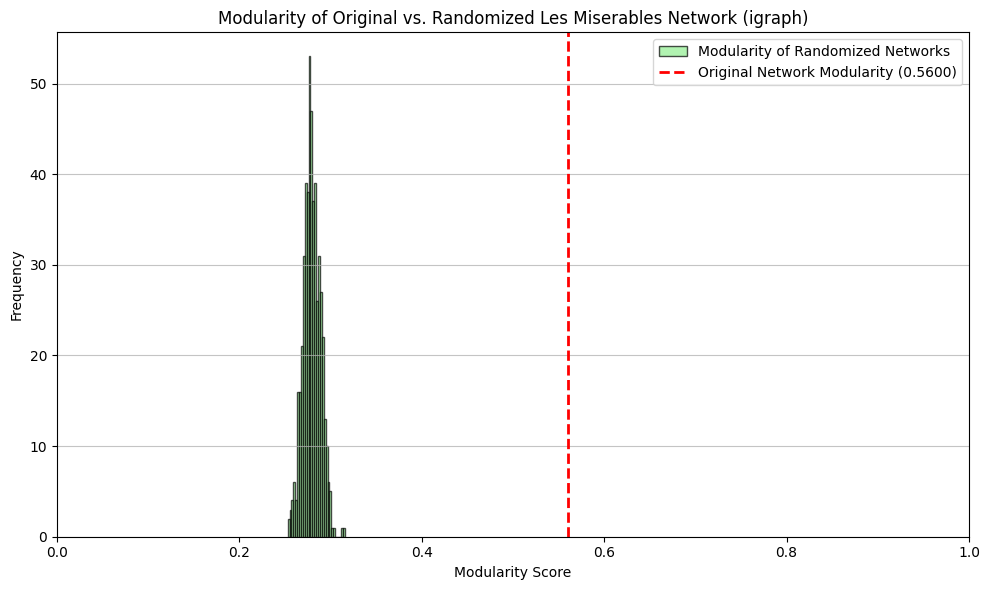

In [15]:
test_community_structure(graph, graph_name="Les Miserables Network")

## Louvain algorithm for clustering

In [16]:

clusters_weighted = community_detection(graph, weight_attribute_name=WEIGHT_ATTRIBUTE_NAME, community_detection_method="multilevel")
clusters_unweighted = community_detection(graph, weight_attribute_name=None, community_detection_method="multilevel")

print(type(clusters_weighted))
# print(clusters_unweighted)

memberships, community_map = report_clustering_details(graph, clusters_unweighted, title="Unweighted Community Detection Results")
print("=================================")
memberships, community_map = report_clustering_details(graph, clusters_weighted, title="Weighted Community Detection Results")

<class 'igraph.clustering.VertexClustering'>

--- Unweighted Community Detection Results ---
Number of communities: 6
Modularity: 0.5600

Communities (showing full member list):
  Community 0 (10 members): Myriel, Napoleon, MlleBaptistine, MmeMagloire, CountessDeLo, Geborand, Champtercier, Cravatte, Count, OldMan
  Community 1 (16 members): Labarre, Valjean, MmeDeR, Isabeau, Gervais, Fauchelevent, Bamatabois, Scaufflaire, Woman1, Judge, Champmathieu, Brevet, Chenildieu, Cochepaille, MotherInnocent, Gribier
  Community 2 (11 members): Marguerite, Tholomyes, Listolier, Fameuil, Blacheville, Favourite, Dahlia, Zephine, Fantine, Perpetue, Simplice
  Community 3 (11 members): MmeThenardier, Thenardier, Javert, Boulatruelle, Eponine, Anzelma, Gueulemer, Babet, Claquesous, Montparnasse, Brujon
  Community 4 (12 members): Cosette, Pontmercy, Woman2, Gillenormand, Magnon, MlleGillenormand, MmePontmercy, MlleVaubois, LtGillenormand, Marius, BaronessT, Toussaint
  Community 5 (17 members): Jondre

### Analyze Differences

In [17]:
if clusters_weighted is not None:
    print("\n--- Analysis of Differences ---")
    print("Modularity comparison:")
    print(f"  Unweighted Modularity: {clusters_unweighted.modularity:.4f}")
    print(f"  Weighted Modularity:   {clusters_weighted.modularity:.4f}")

    print("\nNumber of communities comparison:")
    print(f"  Unweighted Communities: {len(clusters_unweighted)}")
    print(f"  Weighted Communities:   {len(clusters_weighted)}")


    ami = ig.compare_communities(clusters_unweighted, clusters_weighted, method="ami")
    vi = ig.compare_communities(clusters_unweighted, clusters_weighted, method="vi")
    print(f"\nAdjusted Mutual Information (AMI) between unweighted and weighted communities: {ami:.4f}")
    print(f"Variation of Information (VI) between unweighted and weighted communities: {vi:.4f}")
    print("  (AMI closer to 1 indicates high similarity, VI closer to 0 indicates high similarity)")
else:
    print("\nSkipping comparison of differences as weighted clusters were not calculated.")


--- Analysis of Differences ---
Modularity comparison:
  Unweighted Modularity: 0.5600
  Weighted Modularity:   0.5654

Number of communities comparison:
  Unweighted Communities: 6
  Weighted Communities:   6

Adjusted Mutual Information (AMI) between unweighted and weighted communities: 0.6812
Variation of Information (VI) between unweighted and weighted communities: 0.5895
  (AMI closer to 1 indicates high similarity, VI closer to 0 indicates high similarity)


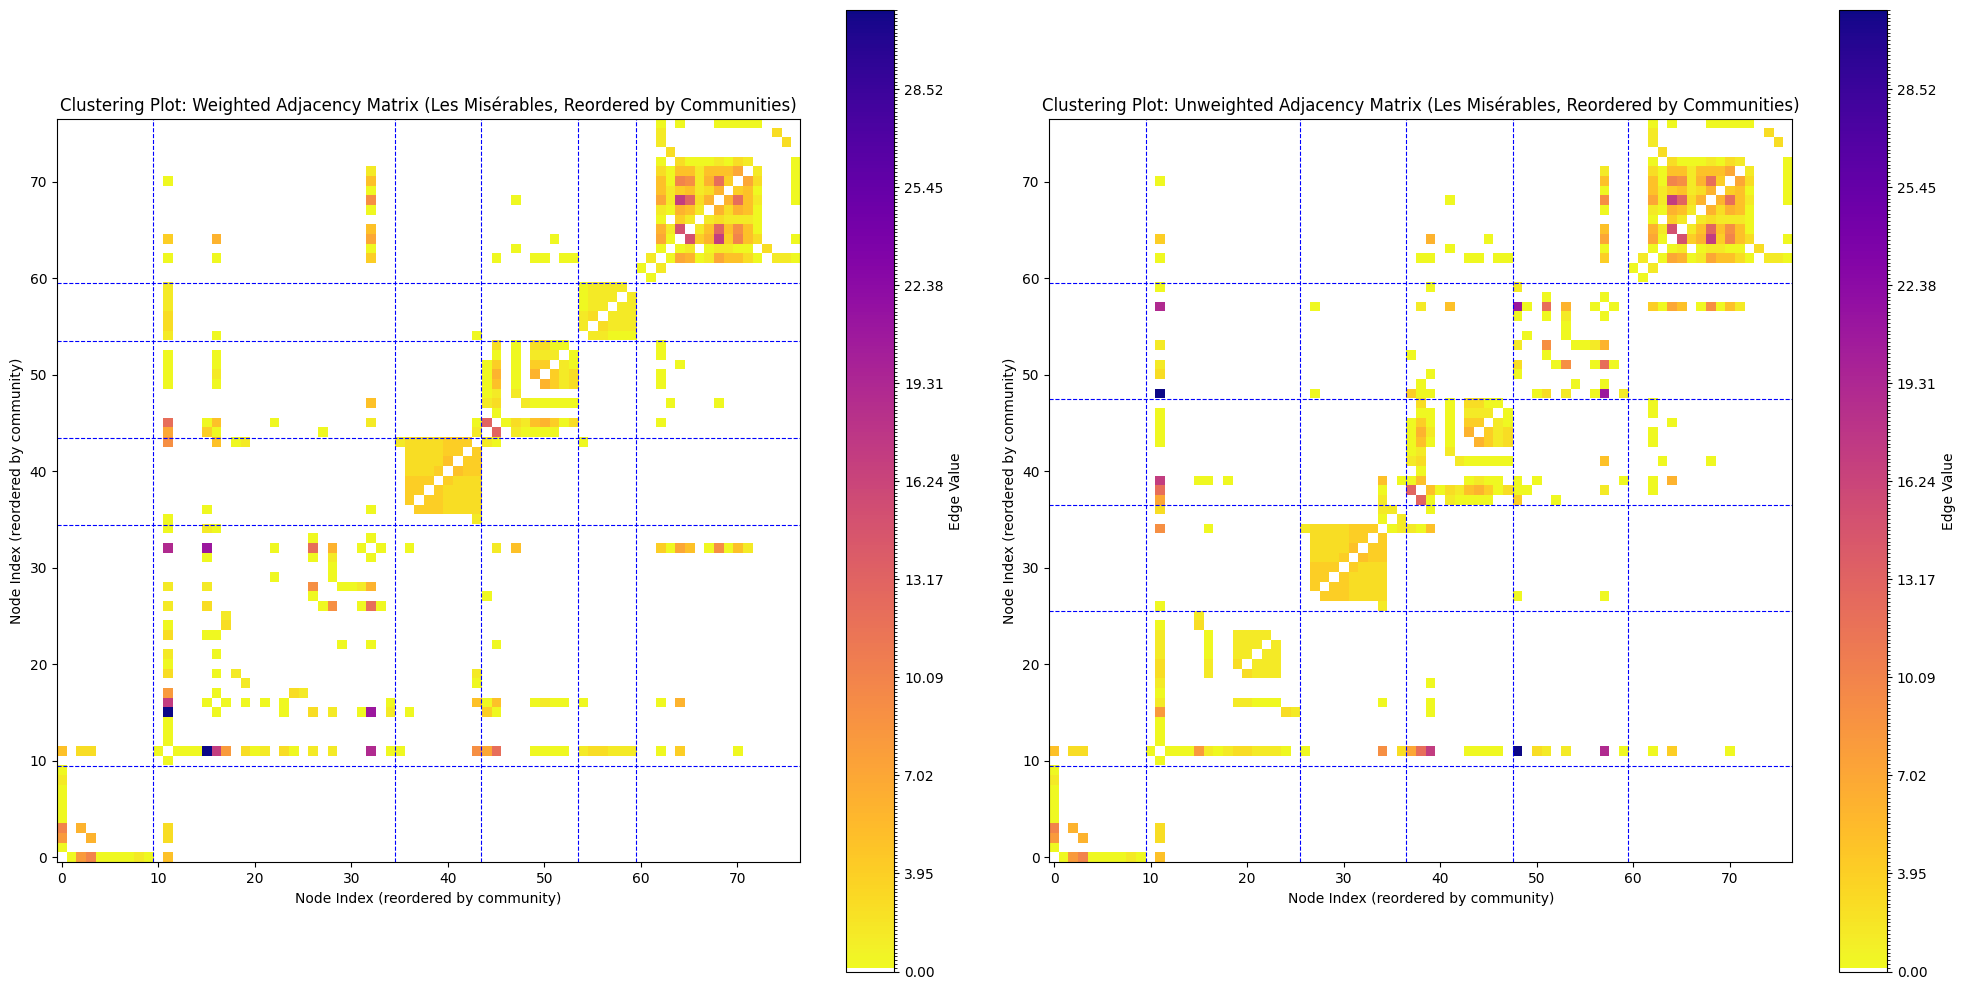

In [ ]:
WEIGHT_ATTRIBUTE_NAME = "value"

args = {
    "graph1": graph,
    "communities1": clusters_weighted,
    "title1": 'Clustering Plot: Weighted Adjacency Matrix (Les Misérables, Reordered by Communities)',
    "graph2": graph,
    "communities2": clusters_unweighted,
    "title2": 'Clustering Plot: Unweighted Adjacency Matrix (Les Misérables, Reordered by Communities)',
    "weight_attribute_name": WEIGHT_ATTRIBUTE_NAME,
}

plot_two_clustered_matrices(**args, plot_type="adjacency_matrix")
plot_two_clustered_matrices(**args, plot_type="shading")

## Fast Greedy algorithm for clustering

In [ ]:

clusters_weighted = community_detection(graph, weight_attribute_name=WEIGHT_ATTRIBUTE_NAME, community_detection_method="fastgreedy")
clusters_unweighted = community_detection(graph, weight_attribute_name=None, community_detection_method="fastgreedy")

memberships, community_map = report_clustering_details(graph, clusters_unweighted, title="Unweighted Community Detection Results")
print("=================================")
memberships, community_map = report_clustering_details(graph, clusters_weighted, title="Weighted Community Detection Results")

### Analyze Differences

In [ ]:
if clusters_weighted is not None:
    print("\n--- Analysis of Differences ---")
    print("Modularity comparison:")
    print(f"  Unweighted Modularity: {clusters_unweighted.modularity:.4f}")
    print(f"  Weighted Modularity:   {clusters_weighted.modularity:.4f}")

    print("\nNumber of communities comparison:")
    print(f"  Unweighted Communities: {len(clusters_unweighted)}")
    print(f"  Weighted Communities:   {len(clusters_weighted)}")


    ami = ig.compare_communities(clusters_unweighted, clusters_weighted, method="ami")
    vi = ig.compare_communities(clusters_unweighted, clusters_weighted, method="vi")
    print(f"\nAdjusted Mutual Information (AMI) between unweighted and weighted communities: {ami:.4f}")
    print(f"Variation of Information (VI) between unweighted and weighted communities: {vi:.4f}")
    print("  (AMI closer to 1 indicates high similarity, VI closer to 0 indicates high similarity)")
else:
    print("\nSkipping comparison of differences as weighted clusters were not calculated.")

In [ ]:
WEIGHT_ATTRIBUTE_NAME = "value"

args = {
    "graph1": graph,
    "communities1": clusters_weighted,
    "title1": 'Clustering Plot: Weighted Adjacency Matrix (Les Misérables, Reordered by Communities)',
    "graph2": graph,
    "communities2": clusters_unweighted,
    "title2": 'Clustering Plot: Unweighted Adjacency Matrix (Les Misérables, Reordered by Communities)',
    "weight_attribute_name": WEIGHT_ATTRIBUTE_NAME,
}

plot_two_clustered_matrices(**args, plot_type="adjacency_matrix")
plot_two_clustered_matrices(**args, plot_type="shading")